# Velib

Velib is the name of the bike sharing system of Paris.
Many people uses Velib to move around the city by staying healthy at the same time.

This system is used by so many people that data collection has become a vital part of the mantainance of the service, by estimating the density of the use we can predict the cost of mantainance by estimating the amount of usage, or provide more bikes where the service is more needed.

Data is structured as follow:
* Every minute data is collected from the 1217 stations in all paris.

* histo: a matrix (1217xminutes) the number of velib disponibles.

* take: a matrix (1217xminutes) the number of velib taken.

* stations: id_velib -> name,address,coord_y,coord_x,banking,bonus,number or places
 * id_velib are sparse, between {903 - 44102}
* idx_stations: id_velib -> matrix index (histo,take)
* stations_idx: matrix index (histo,take) -> id_velib

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fname = "velib.npz"
obj = np.load(fname)

histo = obj['histo']
take = obj['take']
stations = dict(obj['stations'].tolist())
idx_stations = dict(obj['idx_stations'].tolist())
stations_idx = dict(obj['stations_idx'].tolist()) 


# Density estimation.

We'll use the parzen window method to estimate the density function of the random variable: the amount of bikes at a given position.


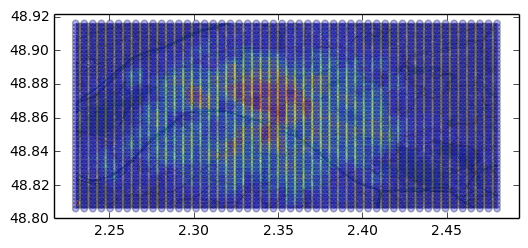

In [86]:
# load the image to plot data onto
parismap = mpimg.imread('paris-48.806-2.23--48.916-2.48.jpg')
## GPS coordinates
xmin,xmax = 2.23,2.48   ## coord_x min and max
ymin,ymax = 48.806,48.916 ## coord_y min and max

# create the data to contain the coordinates for each station
geo_mat = np.zeros((len(idx_stations),2))
for i,idx in idx_stations.items():
    geo_mat[i,0] =stations[idx][3]
    geo_mat[i,1]= stations[idx][2]

steps = 50
xx,yy = np.meshgrid(np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps))
grid = np.c_[xx.ravel(),yy.ravel()]
density = np.zeros((steps,steps))
h = (xmax-xmin)/steps

def parzen_estimation(x,y,h):
    acc = 0
    for positions in geo_mat:
        if np.abs(positions[0] - x)<h and np.abs(positions[1] - y)<h:
            acc+= 1
    return acc

for i,j in [(i,j) for i in range(steps) for j in range(steps)]:
    density[i,j] = parzen_estimation(xx[i,j],yy[i,j],h)
    
plt.imshow(parismap,extent=[xmin,xmax,ymin,ymax],aspect=1.5)
plt.imshow(density,extent=[xmin,xmax,ymin,ymax],interpolation='none',\
               alpha=0.3,origin = "lower")
#plt.scatter(xx[:,:],yy[:,:],alpha=0.3)
plt.show()
